# Learning value-function in blackjack

In [2]:
using Random
using Plots
using StatsBase

In [3]:
newx = [CartesianIndex()]
deck = collect(1:13)
deck[end-2:end] .= 10
println(deck)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


* **Stick**: Player stops
* **Hit**: Request an additional card

In [4]:
"""
Draw a card from an i.i.d deck.
Values of 10 correspond to cards 10, Jack, Queen, and King.
"""
function draw_cards(n=1)
    n_vals = ones(10)
    n_vals[end] = 4
    deck_probs = ProbabilityWeights(n_vals) # Unnormalised probabilities
    cards = n == 1 ? sample(deck_probs) : sample(1:10, deck_probs, n)
    
    return cards
end


"""
Update the value of the player if she has a usable
ace at a given turn.
"""
function update_value_cards(value_cards, has_usable_ace)
    new_card = draw_cards(1)
    value_card, usable_ace = (value_cards <= 10) && (new_card == 1) ? (11, true) : (new_card, false)
    value_cards = value_cards + value_card
    has_usable_ace = has_usable_ace || usable_ace
    
    return value_cards, has_usable_ace
end


"""
Random initialisation of the player's card. At the
beginning, we draw two cards. If the sum of the cards
is less than 12, we continue hitting until we reach at
least 12.

Returns
-------
* Initial cards
* Initial value of cards
* Whether there is a usable ace
"""
function init_state()
    init_cards = draw_cards(2)
    has_usable_ace = any(1 .∈ init_cards)
    
    value_cards = sum(init_cards) + 10 * has_usable_ace
    
    while value_cards < 12
        value_cards, has_usable_ace = update_value_cards(value_cards, has_usable_ace)
    end
    
    return init_cards, value_cards, has_usable_ace 
end


"""
Create initial state of Blackjack game

Returns
-------
* array: sum of player's hand, whether player holds a usable ace, dealer's only showing card
* int: initial value of dealer's hand
"""
function init_game()
    _, player_value, player_usable_ace = init_state()
    dealer_cards, dealer_value, _ = init_state()
    dealer_card = dealer_cards[1]
    
    init_player_state = [player_value, player_usable_ace, dealer_card], dealer_value
end


"""
Return the reward when one of the players has value greater than
21
"""
function evaluate_loss(dealer_value, player_value)
    if dealer_value > 21 && player_value > 21
        reward = 0
    elseif dealer_value > 21 && player_value <= 21
        reward = 1
    elseif dealer_value <= 21 && player_value > 21
        reward = -1
    end
    return reward
end


"""
Compute a single step of Blackjack

Parameters
----------
state: array(3)
    * Player's current sum
    * Whether player has usable ace
    * Dealer's one-showing card
policy array(10, 2, 10)
    Policy grid specifying whether to "hit"
    or "stick". The dimensions are specified as follows:
    1. Index of card values: 12, ..., 21
    2. Action values: hit, stick
    3. Dealer's one-showing card: 1, ..., 10
"""
function blackjack_step(state, dealer_value, policy)
    # end_of_game = false
    reward = 0
    player_val, usable_ace, dealer_card = state
    
    usable_ace = Bool(usable_ace) # Whether player hold a usable ace
    player_ix = player_val - 11 # From value card to index in policy grid
    ace_ix = usable_ace + 1 # From bool to index in policy grid

    
    # Check whether player wants another card
    if player_ix <= 10
        hit_player = Bool(policy[player_ix, ace_ix, dealer_card])
    else
        # Player is out of bounds: losses game
        hit_player = 0
    end
    
    # ** End states **
    # It's a draw
    if player_val == dealer_value == 21
        end_of_game = true
    # Player wins with 21
    elseif player_val == 21
        reward = 1
        end_of_game = true
    # Dealer wins with 21
    elseif dealer_value == 21
        reward = -1
        end_of_game = true
    # One of the players has value above 21
    elseif dealer_value > 21 || player_val > 21
        reward = evaluate_loss(dealer_value, player_val)
        end_of_game = true
    # No player wants to hit
    elseif dealer_value >= 17 && !hit_player
        reward = dealer_value > player_val ? -1 : 1
        end_of_game = true
    # ** Continue playing **
    elseif dealer_value < 17 && !hit_player
        dealer_value = dealer_value + draw_cards()
        end_of_game = false
    elseif dealer_value >= 17 && hit_player
        player_val = player_val + draw_cards()
        end_of_game = false
    elseif dealer_value < 17 && hit_player
        dealer_value, _ = update_value_cards(dealer_value, true)
        player_val, usable_ace = update_value_cards(player_val, usable_ace)
        end_of_game = false
    end
    
    new_state = [player_val, usable_ace, dealer_card]
    return new_state, dealer_value, reward, end_of_game
    
end


"""
Play a 1v1 game of blacjack

Returns
-------
game_hist: Array{N, 5} of N steps and
    1. player's card value
    2. player has usable ace (bool)
    3. dealer's one-showing card
    4. dealer's card value
    5. step reward
"""
function blackjack(policy)
    eog = false # end-of-game
    reward = 0
    state, dealer_value = init_game()
    game_hist = [state; dealer_value; 0][newx, :]

    while !eog
        state, dealer_value, reward, eog = blackjack_step(state, dealer_value, policy)
        new_step = [state; dealer_value; reward][newx, :]
        if !eog
            game_hist = vcat(game_hist, new_step)
        end
    end
    # offsetting rewards one place back
    game_hist[:, end] = [game_hist[2:end, end]; reward]
    
    return game_hist, reward
end

blackjack

In [5]:
# Initial test policy
policy = zeros((10, 2, 10))
policy[1:end-2, 1, :] .= 1 # Sum less than 20 => hits
policy[end-2:end, 1, :] .= 1; # Sum == 20 or sum == 21 => stick

episode_hist, reward = blackjack(policy)
episode_hist

2×5 Matrix{Int64}:
 19  0  7  14  0
 25  0  7  24  0

### Policy evaluation

In this section, we simulate many blackjack games and average the returns following each state

In [6]:
function array_in_arrays(array, arrays)
    assertion_table = in.(array, arrays)
    assert = any(mapslices(all, assertion_table; dims=2))
    return assert
end

array_in_arrays (generic function with 1 method)

In [7]:
# total sum of returns for all history
returns = zeros(size(policy))
# count of times a state was visited
counts = zeros(size(policy))

Random.seed!(314)
for _ in 1:500_000
    episode_hist, _ = blackjack(policy)
    visited_states = [0 0 0]
    for row in eachrow(episode_hist)
        player_val, ace_val, dealer_card, _, reward = row

        player_ix = player_val - 11
        ace_ix = ace_val + 1
        dealer_ix = dealer_card

        state_ix = [player_ix ace_ix dealer_ix]

        # Update if state hasn't been observed and we are inside
        # a valid state
        if !array_in_arrays(state_ix, visited_states) && player_ix <= 10
            visited_states = vcat(visited_states, state_ix)
            returns[player_ix, ace_ix, dealer_ix] += reward
            counts[player_ix, ace_ix, dealer_ix] += 1
        end
    end
end

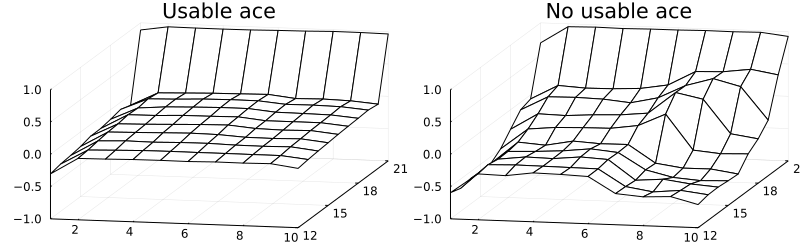

In [8]:
Vπ = returns ./ counts;

p1 = plot(1:10, 12:21, Vπ[:, 1, :], st=:wireframe, title="Usable ace", zlim=(-1, 1), camera=(20, 45))
p2 = plot(1:10, 12:21, Vπ[:, 2, :], st=:wireframe, title="No usable ace", zlim=(-1, 1), camera=(20, 45))

plot(p1, p2, size=(800, 250))